In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import log as log_link
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import Independence
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error

<h1>Feature engineering<h1>

In [2]:
df = pd.read_csv("hdb_with_mrt_info.csv")

# Count occurrences of each street name
street_counts = df['street_name'].value_counts()

# Filter to keep only street names with at least 100 observations
valid_streets = street_counts[street_counts >= 100].index
df = df[df['street_name'].isin(valid_streets)]

# Number of unique street names remaining
num_unique_streets = df['street_name'].nunique()
print(num_unique_streets)

439


We need to transform categorical variables into numerical variables. We will one-hot encode town and street_name, and ordinal encode flat_type, distance_from_expressway and storey_range since these variables have underlying rank. 

In [3]:
town_oh = pd.get_dummies(df['town'], prefix='town', drop_first=True)
# street_oh = pd.get_dummies(df['street_name'], prefix='street', drop_first=True)

print(town_oh.shape)
# print(street_oh.shape)

ref_town = sorted(df['town'].unique())[0]
print(f"Reference category for town is: {ref_town}")

# ref_street = sorted(df['street_name'].unique())[0]
# print(f"Reference category for street is: {ref_street}")

(211584, 25)
Reference category for town is: ANG MO KIO


In [4]:
# Ordinal encode flat_type
flat_order = ["1 ROOM", "2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", "MULTI-GENERATION"]
df['flat_type'] = pd.Categorical(df['flat_type'], categories=flat_order, ordered=True)
df['flat_type_ord'] = df['flat_type'].cat.codes + 1  # +1 to match R's 1-based index

# Ordinal encode distance_from_expressway
expressway_levels = ["<=50m", "51-100m", "101-150m", "151-300m", "301-500m", ">500m"]
df['distance_from_expressway'] = pd.Categorical(df['distance_from_expressway'],
                                                categories=expressway_levels, ordered=True)
df['distance_expressway_ord'] = df['distance_from_expressway'].cat.codes + 1

# Ordinal encode storey_range
storey_levels = [
    "01 TO 03", "04 TO 06", "07 TO 09", "10 TO 12", "13 TO 15",
    "16 TO 18", "19 TO 21", "22 TO 24", "25 TO 27", "28 TO 30",
    "31 TO 33", "34 TO 36", "37 TO 39", "40 TO 42", "43 TO 45",
    "46 TO 48", "49 TO 51"
]
df['storey_range'] = pd.Categorical(df['storey_range'], categories=storey_levels, ordered=True)
df['storey_range_ord'] = df['storey_range'].cat.codes + 1


print(df[['flat_type', 'flat_type_ord']].head())
print(df[['distance_from_expressway', 'distance_expressway_ord']].head())
print(df[['storey_range', 'storey_range_ord']].head())

  flat_type  flat_type_ord
0    2 ROOM              2
1    3 ROOM              3
2    3 ROOM              3
3    3 ROOM              3
4    3 ROOM              3
  distance_from_expressway  distance_expressway_ord
0                    >500m                        6
1                    >500m                        6
2                    >500m                        6
3                 151-300m                        4
4                    >500m                        6
  storey_range  storey_range_ord
0     10 TO 12                 4
1     01 TO 03                 1
2     01 TO 03                 1
3     04 TO 06                 2
4     01 TO 03                 1


In [5]:
# merge df with one hot matrix
df_final = pd.concat([df, town_oh], axis=1)

# Drop unused categorical and spatial columns
drop_cols = [
    "town", "flat_type", "block", "street_name", "storey_range",
    "storey_range_category", "distance_from_expressway", "latitude", 
    "longitude", "address", "postal", "nearest_mrt"
]

In [6]:
df_final = df_final.drop(columns=drop_cols, errors='ignore')
df_final = df_final.astype({col: 'int' for col in df_final.select_dtypes(include='bool').columns})

# Check final columns
print(df_final.columns)
print(df_final.shape)


Index(['year', 'floor_area_sqm', 'remaining_lease_years', 'resale_price',
       'num_nearby_mrts', 'nearest_mrt_distance', 'flat_type_ord',
       'distance_expressway_ord', 'storey_range_ord', 'town_BEDOK',
       'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN'],
      dtype='object')
(211584, 34)


<h1>Modeling<h1>

In [7]:
# Set random seed
random_state = 123

# Split the final dataframe
X = df_final.drop(columns='resale_price')
y = df_final['resale_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

# check dimensions
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(169267, 33) (42317, 33)
(169267,) (42317,)


In [8]:
# Fit OLS
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model_ols = sm.OLS(y_train, X_train_sm).fit()
print(model_ols.summary())

# Predict on test set
y_pred_ols = model_ols.predict(X_test_sm)

# Compute test RMSE
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
print(f"Test RMSE (OLS): {rmse_ols:,.2f} SGD")

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                 2.844e+04
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        03:19:43   Log-Likelihood:            -2.1198e+06
No. Observations:              169267   AIC:                         4.240e+06
Df Residuals:                  169233   BIC:                         4.240e+06
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -4

In [9]:
# check vif
vif_df = pd.DataFrame()
vif_df["feature"] = X_train.columns
vif_df["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_df.sort_values(by="VIF", ascending=False).head(10))

                    feature         VIF
5             flat_type_ord  269.214980
1            floor_area_sqm  226.197928
0                      year  103.489183
2     remaining_lease_years   54.996954
6   distance_expressway_ord   29.104658
3           num_nearby_mrts   10.015509
4      nearest_mrt_distance    7.250054
24             town_PUNGGOL    5.214292
27            town_SENGKANG    4.856139
7          storey_range_ord    4.622624


<h2>Regularized linear models<h2>

In [10]:
# Candidate alpha values
alphas = np.logspace(-2, 4, 50)

# --- RidgeCV ---
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)
ridge_best_alpha = ridge_cv.alpha_
y_pred_ridge = ridge_cv.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"Test RMSE Ridge: {rmse_ridge:,.2f} SGD")
print(f"[Ridge] Best alpha: {ridge_best_alpha}")


# --- LassoCV ---
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)
lasso_best_alpha = lasso_cv.alpha_
y_pred_lasso = lasso_cv.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"Test RMSE Lasso: {rmse_lasso:,.2f} SGD")
print(f"[Lasso] Best alpha: {lasso_best_alpha}")



Test RMSE Ridge: 66,565.31 SGD
[Ridge] Best alpha: 0.054286754393238594
Test RMSE Lasso: 66,565.32 SGD
[Lasso] Best alpha: 0.01


<h2>log transform<h2>

In [11]:
# Log-transform y
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# OLS 
model_ols_log = sm.OLS(y_train_log, X_train_sm).fit()
print(model_ols_log.summary())

y_pred_ols_log = model_ols_log.predict(X_test_sm)
y_pred_ols = np.exp(y_pred_ols_log)  # Back-transform to original scale

rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
print(f"Test RMSE (log-OLS): {rmse_ols:,.2f} SGD")

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                 3.548e+04
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        03:20:56   Log-Likelihood:             1.2110e+05
No. Observations:              169267   AIC:                        -2.421e+05
Df Residuals:                  169233   BIC:                        -2.418e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [12]:
# Ridge after applying log transformation
alphas = np.logspace(-2, 4, 50)
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train_log)
y_pred_ridge_log = ridge_cv.predict(X_test)
y_pred_ridge = np.exp(y_pred_ridge_log)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"Test RMSE (log-Ridge): {rmse_ridge:,.2f} SGD")

# Lasso after applying log transformation
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train_log)
y_pred_lasso_log = lasso_cv.predict(X_test)
y_pred_lasso = np.exp(y_pred_lasso_log)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"Test RMSE (log-Lasso): {rmse_lasso:,.2f} SGD")



Test RMSE (log-Ridge): 58,471.89 SGD
Test RMSE (log-Lasso): 101,586.58 SGD


<h2>Gamma Regression<h2>

In [13]:
# Fit Gamma regression model with log link
model_gamma = sm.GLM(y_train, X_train_sm, family=Gamma(link=log_link()))
results_gamma = model_gamma.fit()

# Summary of coefficients (like summary(model_gamma) in R)
print(results_gamma.summary())

# Predict on test set (on original scale)
y_pred_gamma = results_gamma.predict(X_test_sm)

# Compute Test RMSE
mse_gamma = mean_squared_error(y_test, y_pred_gamma)
rmse_gamma = np.sqrt(mse_gamma)
print(f"Test RMSE (Gamma): {rmse_gamma:,.2f} SGD")

c:\Users\zyj25\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:           resale_price   No. Observations:               169267
Model:                            GLM   Df Residuals:                   169233
Model Family:                   Gamma   Df Model:                           33
Link Function:                    log   Scale:                        0.014154
Method:                          IRLS   Log-Likelihood:            -2.0872e+06
Date:                Tue, 13 May 2025   Deviance:                       2369.7
Time:                        03:21:22   Pearson chi2:                 2.40e+03
No. Iterations:                    12   Pseudo R-squ. (CS):             0.9990
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

<>:25: SyntaxWarning: invalid escape sequence '\h'
<>:27: SyntaxWarning: invalid escape sequence '\h'
<>:25: SyntaxWarning: invalid escape sequence '\h'
<>:27: SyntaxWarning: invalid escape sequence '\h'
C:\Users\zyj25\AppData\Local\Temp\ipykernel_31428\1215054935.py:25: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel("Average predicted mean $\hat{\\mu}$")
C:\Users\zyj25\AppData\Local\Temp\ipykernel_31428\1215054935.py:27: SyntaxWarning: invalid escape sequence '\h'
  plt.title("Empirical Var($Y$) vs $\hat{\\mu}$")
C:\Users\zyj25\AppData\Local\Temp\ipykernel_31428\1215054935.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_diag.groupby('bin').agg(


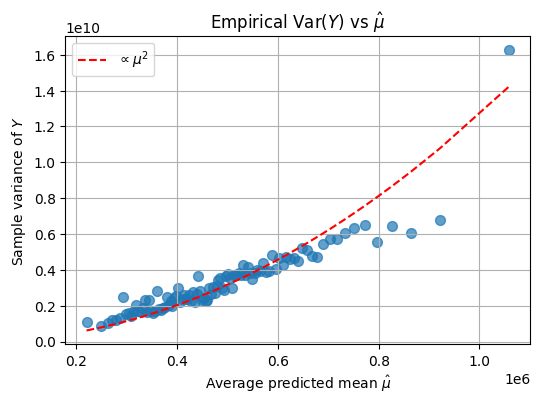

In [14]:
# check Gamma Regression assumption: variance is proportional to mean square
y_true = np.asarray(y_test)
mu_hat = np.asarray(y_pred_gamma)

df_diag = pd.DataFrame({
    'y_true': y_true,
    'mu_hat': mu_hat
})

# Bin mu_hat
n_bins = 100
df_diag['bin'] = pd.qcut(df_diag['mu_hat'], q=n_bins, duplicates='drop')

# each bin, compute sample variance 
grouped = df_diag.groupby('bin').agg(
    avg_mu=('mu_hat', 'mean'),
    var_y = ('y_true', 'var')
).reset_index(drop=True)

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(grouped['avg_mu'], grouped['var_y'], s=50, alpha=0.7)
plt.plot(grouped['avg_mu'], grouped['avg_mu']**2 * grouped['var_y'].mean() / (grouped['avg_mu']**2).mean(),
         color='red', linestyle='--', label=r'$\propto \mu^2$')
plt.xlabel("Average predicted mean $\hat{\\mu}$")
plt.ylabel("Sample variance of $Y$")
plt.title("Empirical Var($Y$) vs $\hat{\\mu}$")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
log_resid2 = np.log((y_test - mu_hat)**2)
log_mu = np.log(mu_hat)

X_reg = sm.add_constant(log_mu)
model_var = sm.OLS(log_resid2, X_reg).fit()
print(model_var.summary())

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1590.
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        03:21:23   Log-Likelihood:                -93174.
No. Observations:               42317   AIC:                         1.864e+05
Df Residuals:                   42315   BIC:                         1.864e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6467      0.450      5.886      0.0

<h2>proportional odds logistic model<h2>

In [16]:
# Create decile-based bin cutpoints
quantiles = np.quantile(y_train, q=np.linspace(0, 1, 11))

# Ensure no duplicated cutpoints
for i in range(1, len(quantiles)):
    if quantiles[i] <= quantiles[i-1]:
        quantiles[i] = quantiles[i-1] + 1e-5 
        

# Discretize y_train into 10 ordered bins (1 to 10)
y_train_ord = pd.cut(y_train, bins=quantiles, labels=False, include_lowest=True) + 1
y_train_ord = pd.Series(y_train_ord, name='y_ord').astype("category")
y_train_ord = y_train_ord.cat.as_ordered()

# Fit proportional odds logistic model
train_ord_df = pd.concat([y_train_ord, X_train], axis=1)
model_polr = OrderedModel(
    endog=train_ord_df["y_ord"],
    exog=train_ord_df.drop(columns="y_ord"),
    distr="logit"  
)

result_polr = model_polr.fit(method="bfgs", disp=False)
print(result_polr.summary())

                             OrderedModel Results                             
Dep. Variable:                  y_ord   Log-Likelihood:            -2.3412e+05
Model:                   OrderedModel   AIC:                         4.683e+05
Method:            Maximum Likelihood   BIC:                         4.687e+05
Date:                Tue, 13 May 2025                                         
Time:                        03:35:57                                         
No. Observations:              169267                                         
Df Residuals:                  169225                                         
Df Model:                          33                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
year                        0.6917        nan        nan        nan         nan         nan
floor_area_sq

c:\Users\zyj25\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
